
## The ARIMA model in use: forecasting time series


#### RENATO POLI
[email](rebpoli@gmail.com) | [GitHub](https://github.com/rebpoli/MachineLearning)

#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
### Subsurface Machine Learning Course, The University of Texas at Austin

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Maria Gonzalez, Graduate Student, The University of Texas at Austin (mfg987@my.utexas.edu)


### Executive Summary

I designed an ARIMA(p,d,q) workflow to forecast time series using different test/train splits and hyperparameters. I used synthetic data for the experiments, created to mimic the evolution of river levels in response to different climate dynamics. The goal was to test the forecasting on both stationary and non-stationary data. The workflow demonstrates that ARIMA models the mean, not the range/variance, as the forecast converges to the expected value (mean) at each future time. The model could not forecast the peaks and the periodicity of the test data. This happens because the autoregressive (AR)  component decays exponentially toward the mean, while the moving average (MA) component's effect dies out quickly. When using d=1 to differentiate the series, ARIMA can capture long-term trends (like the climate change river evolution). For the automatic tuning of the hyperparameters, I experimented with Akaike's Information Criterion (AIC) as a quality measure. It worked as expected. However, I could get more control of the forecast by manually looking at the forecasts (ocular inspection). Results show that the tuning tends to use d=1 for small train datasets, while larger datasets are tuned with no differencing (d=0). The tuning was not able to capture the nonstationarity of the mean. I tested manually and obtained different forecasts, more compatible with the testing data and much more sensitive to the size of the training dataset.

### Description of ARIMA(p,d,q)

ARIMA(p,d,q) stands for Autoregressive Integrated Moving Average.
The hyperparameters are:

* **p**: the order of the Autoregressive (AR) part of ARIMA
* **d**: the degree of differencing (I) involved
* **q**: the order of the Moving Average (MA) part

The three parts of the series map different attributes of the data:

* **Autoregressive (AR)**: Assumes that the current value of the series is a linear combination of its own previous values
* **Integrated (I)**: Handles trends in the data by differentiating the series, to make the time series stationary.
* **Moving Average (MA)**: Assumes the current value depends on the past forecast errors.

This workflow intends to understand the ability of ARIMA series to forecast data of river levels along the years.
The objective is to experiment with the hyperparameters and be instructive on the behavior of such algorithms.

#### Import Packages

In [2]:
# Basic stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ARIMA MODEL Model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### Functions

The following functions support the workflows.

In [3]:
#
def simulate_paths(model, steps, n_paths=100, seed=None):
    np.random.seed(seed)
    
    paths = np.zeros((n_paths, steps))
    
    for i in range(n_paths):
        # Simulate from the fitted model
        simulated = model.simulate(
            nsimulations=steps,
            anchor='end',  # Start from end of training data
            repetitions=1
        )
        # Flatten to 1D array if needed
        paths[i, :] = np.array(simulated).flatten()
    
    return paths
    
#
def get_percentiles(paths, percentiles=[5, 25, 50, 75, 95]):
    result = {}
    for p in percentiles:
        result[f'p{p}'] = np.percentile(paths, p, axis=0)
    return result
    
#
def plot_fan_chart(ax, paths, test_series, train_series):
    
    n_train = len(train_series)
    steps = paths.shape[1]
    forecast_idx = range(n_train, n_train + steps)
    
    # Calculate percentiles
    percentiles = get_percentiles(paths)
    
    # Plot train / test
    train_idx = range(n_train)
    ax.plot(train_idx, train_series, 'b-', linewidth=1, label='Train')
    test_idx = range(n_train, n_train + len(test_series))
    ax.plot(test_idx, test_series, 'g-', linewidth=1, label='Test', zorder=10)
    
    # Plot percentile bands (fan chart)
    colors = ['#d62728', '#ff7f0e', '#2ca02c', '#ff7f0e', '#d62728']
    alphas = [0.15, 0.25, 0.35, 0.25, 0.15]
    labels = ['5-95%', '25-75%', 'Median', '', '']
    
    ax.fill_between(forecast_idx, percentiles['p5'], percentiles['p95'], alpha=alphas[0], color=colors[0], label='90% CI')
    ax.fill_between(forecast_idx, percentiles['p25'], percentiles['p75'],alpha=alphas[1], color=colors[1], label='50% CI')
    
    # Median line
    ax.plot(forecast_idx, percentiles['p50'], 'r-', linewidth=1, label='P50')       
   
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('Water Level (m)', fontsize=10)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.grid(True, alpha=0.3)

# Workflow 1: Diagnostics and investigation of a single dataset

## Load a realistic river level data (time series)

These datasets was generated in a separate python notebook.

They simulate the level of a river along a few years.
This first dataset is a stationary data series.

The script that generated the dataset can be found in my github account: [GitHub](https://github.com/rebpoli/MachineLearning)

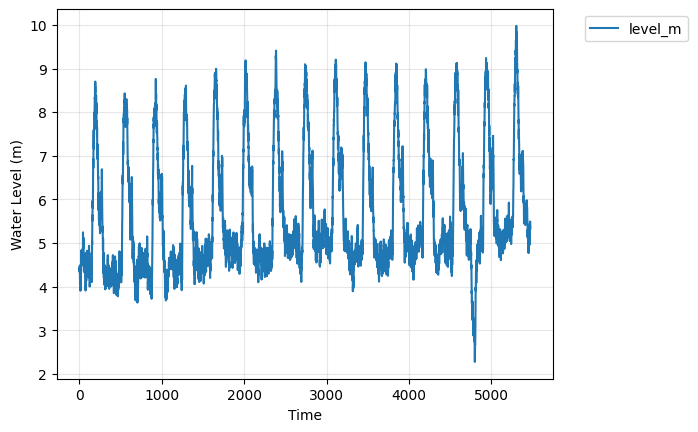

In [6]:
df = pd.read_csv("river_monsoon.csv")
#df = pd.read_csv("river_climate_change.csv")

df['level_m'] = df['level_m'].interpolate(method='linear')

df.plot()
plt.xlabel('Time', fontsize=10)
plt.ylabel('Water Level (m)', fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

## Train / Test split

For this first workflow, we are more interested in the methodology, so we use a fixed 80/20 train/test split.

In [7]:
tt_prop = 0.8
train_size = int(len(df) * tt_prop)
train_df = df[:train_size].copy()
test_df = df[train_size:].copy()

train_series = train_df.set_index('date')['level_m']
test_series = test_df.set_index('date')['level_m']

### Test for stationarity, and get some insight on the autocorrelation functions

**Autocorrelation**: the degree to which a time series is correlated with its past (the relation between $y_t$ and $y_{t-k}$ for multiple values of $k$

**Partial Autocorrelation**: remove a number of lag observations. Measure the relationship between $y_t$ and $y_{t−k}$ after controlling the lags $1$ to $k$. 

Stationarity Test
--------------------------------------------------
ADF Statistic: -6.5992
P-value: 0.0000
Critical Values:
  1%: -3.432
  5%: -2.862
  10%: -2.567
Series is STATIONARY (p < 0.05)


Stationarity Test for the derivative
--------------------------------------------------
ADF Statistic: -14.7602
P-value: 0.0000
Critical Values:
  1%: -3.432
  5%: -2.862
  10%: -2.567
Series DERIVATIVE is STATIONARY (p < 0.05)


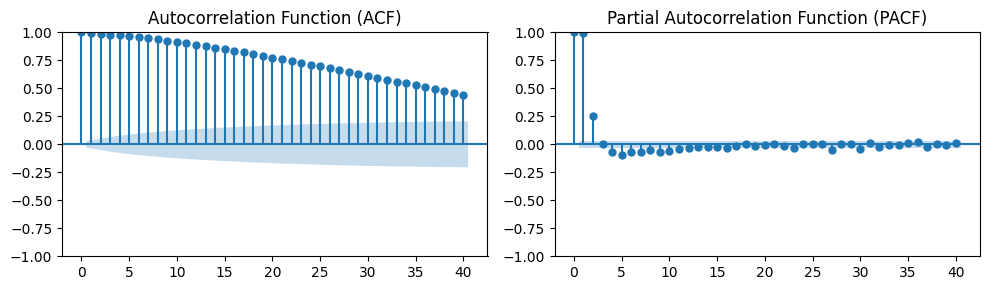

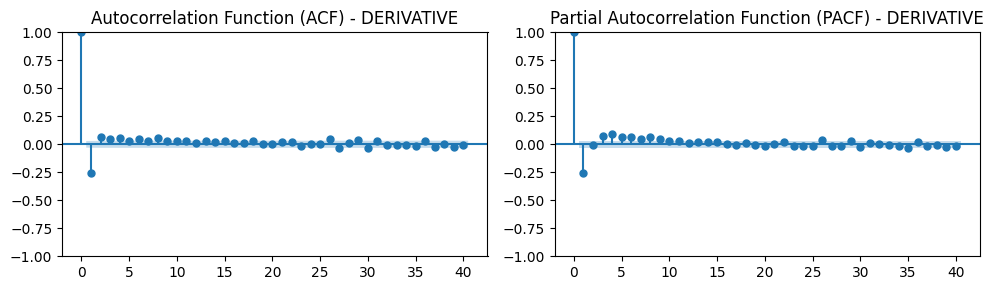

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_series.dropna())
print(f"Stationarity Test")
print("-" * 50)
print(f"ADF Statistic: {result[0]:.4f}")
print(f"P-value: {result[1]:.4f}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value:.3f}")

if result[1] < 0.05:
    print(f"Series is STATIONARY (p < 0.05)")
else:
    print(f"Series is NON-STATIONARY (p >= 0.05)")

first_diff = train_series.diff().dropna(inplace=False)
result = adfuller(first_diff.dropna())
print(f"\n\nStationarity Test for the derivative")
print("-" * 50)
print(f"ADF Statistic: {result[0]:.4f}")
print(f"P-value: {result[1]:.4f}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value:.3f}")

if result[1] < 0.05:
    print(f"Series DERIVATIVE is STATIONARY (p < 0.05)")
else:
    print(f"Series DERIVATIVE is NON-STATIONARY (p >= 0.05)")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_series, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(train_series, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
fig.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_series.diff().dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) - DERIVATIVE')
plot_pacf(train_series.diff().dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) - DERIVATIVE')
fig.tight_layout()

### Hyperparameter tuning

Do the fitting of ARIMA to the data, testing different p and q weights.

In [11]:
max_p = 3
max_q = 5
best_aic = np.inf

d_values = [0]
results = []
for d in d_values:
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            model = ARIMA(train_series, order=(p, d, q))
            fitted = model.fit()
            results.append({
                'p': p, 'd': d, 'q': q,
                'aic': fitted.aic,
                'bic': fitted.bic
            })
            
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_order = (p, d, q)
                best_model = fitted

            #print(f"Tested (p,d,q)=({p},{d},{q}): AIC:{fitted.aic:.2f}  BIC:{fitted.bic:.2f}")


results_df = pd.DataFrame(results).sort_values('aic')

(p,d,q) = best_order
print()
print(f"Best model parameters : (p,d,q)=({p},{d},{q})")


Best model parameters : (p,d,q)=(2,0,3)


### Summary of the best model

Show the quality indicators AIC (Akaike) and BIC (Bayesian) trends.
The results are consistent: both indicators follow the same trend.

In [12]:
print(f"Best model: ARIMA{best_order}")
print(f"  AIC (Akaike Information Criterion)   : {best_model.aic:.2f}")
print(f"  BIC (Bayesian Information Criterion) : {best_model.bic:.2f}")

print("\nTop 10 models by AIC:")
print(results_df.head(10).to_string(index=False))

print("-" * 70)
#print(best_model.summary())

# Step 7: Residual Diagnostics
print("-" * 70)
residuals = best_model.resid
print(f"Residual mean: {residuals.mean():.6f} (should be ~0)")
print(f"Residual std: {residuals.std():.4f}")


Best model: ARIMA(2, 0, 3)
  AIC (Akaike Information Criterion)   : -2820.45
  BIC (Bayesian Information Criterion) : -2775.75

Top 10 models by AIC:
 p  d  q          aic          bic
 2  0  3 -2820.447744 -2775.754116
 3  0  3 -2818.270864 -2767.192432
 2  0  4 -2817.420859 -2766.342427
 2  0  2 -2812.958479 -2774.649655
 3  0  4 -2809.981011 -2752.517775
 3  0  5 -2807.219279 -2743.371239
 2  0  5 -2805.866588 -2748.403352
 1  0  5 -2712.124980 -2661.046548
 1  0  4 -2705.285090 -2660.591462
 1  0  3 -2687.372487 -2649.063663
----------------------------------------------------------------------
----------------------------------------------------------------------
Residual mean: -0.000100 (should be ~0)
Residual std: 0.1758


## Forecasting with the best model

Use the best model to forecast the series, and get some error metrics.

In [14]:
forecast = best_model.forecast(steps=len(test_series))
forecast.index = test_series.index

# Calculate metrics
mae = mean_absolute_error(test_series, forecast)
rmse = np.sqrt(mean_squared_error(test_series, forecast))
mape = np.mean(np.abs((test_series - forecast) / test_series)) * 100

print(f"Forecast Performance:")
print(f"  MAE:  {mae:.3f} meters")
print(f"  RMSE: {rmse:.3f} meters")
print(f"  MAPE: {mape:.2f}%")

print(f"Forecast  (mean): {forecast.mean():.2f}")
print(f"Test data (mean): {test_series.mean():.2f}")
err = ( forecast.mean() - test_series.mean() ) / test_series.mean() 
print(f"--- Error: {err*100:.2f} %")

#fig = plot_diagnostics( train_series, best_model, forecast, test_series, f"River Level ARIMA{best_order} Analysis" )

Forecast Performance:
  MAE:  1.069 meters
  RMSE: 1.492 meters
  MAPE: 17.71%
Forecast  (mean): 5.55
Test data (mean): 5.87
--- Error: -5.55 %


Simulate numerous forecasting paths to create 50% and 90% confidence intervals.
Perform a visual comparison to the test data.

Note that ARIMA cannot forecast peaks consistently, but it offers reasonable confidence intervals for most of the test data.

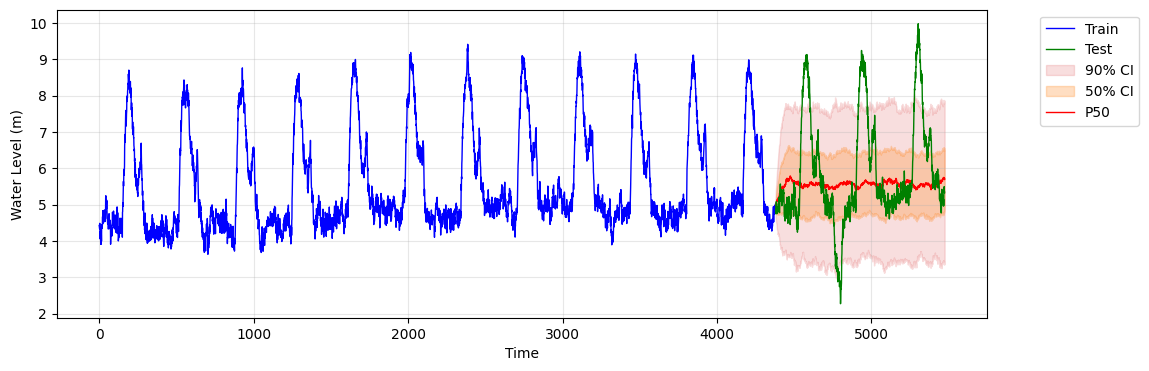

In [15]:
paths = simulate_paths(best_model, steps=len(test_series), n_paths=500, seed=42)

fig, ax = plt.subplots(figsize=(12,4))
fig2 = plot_fan_chart(ax, paths, test_series, train_series)

# Workflow 2. Assess the performance considering different TRAIN/TEST splits

Now we are interested in using different TRAIN/TEST splits.
The question is: how ARIMA performs considering reduced training sets?

#### Support functions for workflow 2

In [16]:
def run_tuning(fname, d_values=[0,1]) :
    max_p = 2
    max_q = 2
    TT_SPLITS = [ 0.05, 0.2, 0.5, 0.7 ]

    results_by_tt = []
    
    for tt_split in TT_SPLITS :
        print(f"Fitting tt_split={tt_split} ...")
        df = pd.read_csv(fname)
        df['level_m'] = df['level_m'].interpolate(method='linear')
    
        # TT SPLIT
        train_size = int(len(df) * tt_split)
        train_df = df[:train_size].copy()
        test_df = df[train_size:].copy()
        train_series = train_df.set_index('date')['level_m']
        test_series = test_df.set_index('date')['level_m']
    
        
        # DO THE FITTING
        best_aic = np.inf   
        results = []
        for d in d_values:
            for p in range(max_p + 1):
                for q in range(max_q + 1):
                    model = ARIMA(train_series, order=(p, d, q))
                    fitted = model.fit()
                    results.append({
                        'p': p, 'd': d, 'q': q,
                        'aic': fitted.aic,
                        'bic': fitted.bic
                    })
                    
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                        best_model = fitted
                        
    #                print(f"Tested (p,d,q)=({p},{d},{q}): AIC:{fitted.aic:.2f}  BIC:{fitted.bic:.2f}")
        results_by_tt.append({
          'tt_split' : tt_split,
          'df' : pd.DataFrame(results).sort_values('aic') ,
          'best_order':best_order,
          'best_model': best_model,
          'paths' : simulate_paths(best_model, steps=len(test_series), n_paths=500, seed=42),
          'forecast' : best_model.forecast(steps=len(test_series)),
          'test_series' : test_series,
          'train_series' : train_series,
          'results_df' : pd.DataFrame(results).sort_values('aic')
        })
    
    print(10*"-")
    print("Done") 

    n_plots = len(TT_SPLITS)

    fig, axes = plt.subplots(n_plots, 1, figsize=(10,3*n_plots))
    for i in range(n_plots) :
        res = results_by_tt[i]
        paths = res['paths']
        test_series = res['test_series']
        train_series = res['train_series']
        plot_fan_chart(axes[i], paths, test_series, train_series)

    for i in range(n_plots) :
        res = results_by_tt[i]
        forecast = res['forecast']
        test_series = res['test_series']
        results_df = res['results_df']
        print(70*"=")
        print(f"Train-test split: {res['tt_split']*100} %")
        print(f"     (p,d,q):{res['best_order']}")
        print(f"     Forecast  (mean): {forecast.mean():.2f}")
        print(f"     Test data (mean): {test_series.mean():.2f}")
        err = ( forecast.mean() - test_series.mean() ) / test_series.mean() 
        print(f"     -> Error: {err*100:.2f} %")
        # print("\n\nTop 10 models by AIC:")
        # print(results_df.head(10).to_string(index=False))

## WF 2A) Test with a stationary series

Use the same series as in Workflow 1.

Fitting tt_split=0.05 ...
Fitting tt_split=0.2 ...
Fitting tt_split=0.5 ...
Fitting tt_split=0.7 ...
----------
Done
Train-test split: 5.0 %
     (p,d,q):(2, 0, 0)
     Forecast  (mean): 5.52
     Test data (mean): 5.62
     -> Error: -1.88 %
Train-test split: 20.0 %
     (p,d,q):(2, 0, 2)
     Forecast  (mean): 5.12
     Test data (mean): 5.72
     -> Error: -10.47 %
Train-test split: 50.0 %
     (p,d,q):(2, 0, 2)
     Forecast  (mean): 5.43
     Test data (mean): 5.82
     -> Error: -6.63 %
Train-test split: 70.0 %
     (p,d,q):(2, 0, 2)
     Forecast  (mean): 5.61
     Test data (mean): 5.88
     -> Error: -4.65 %


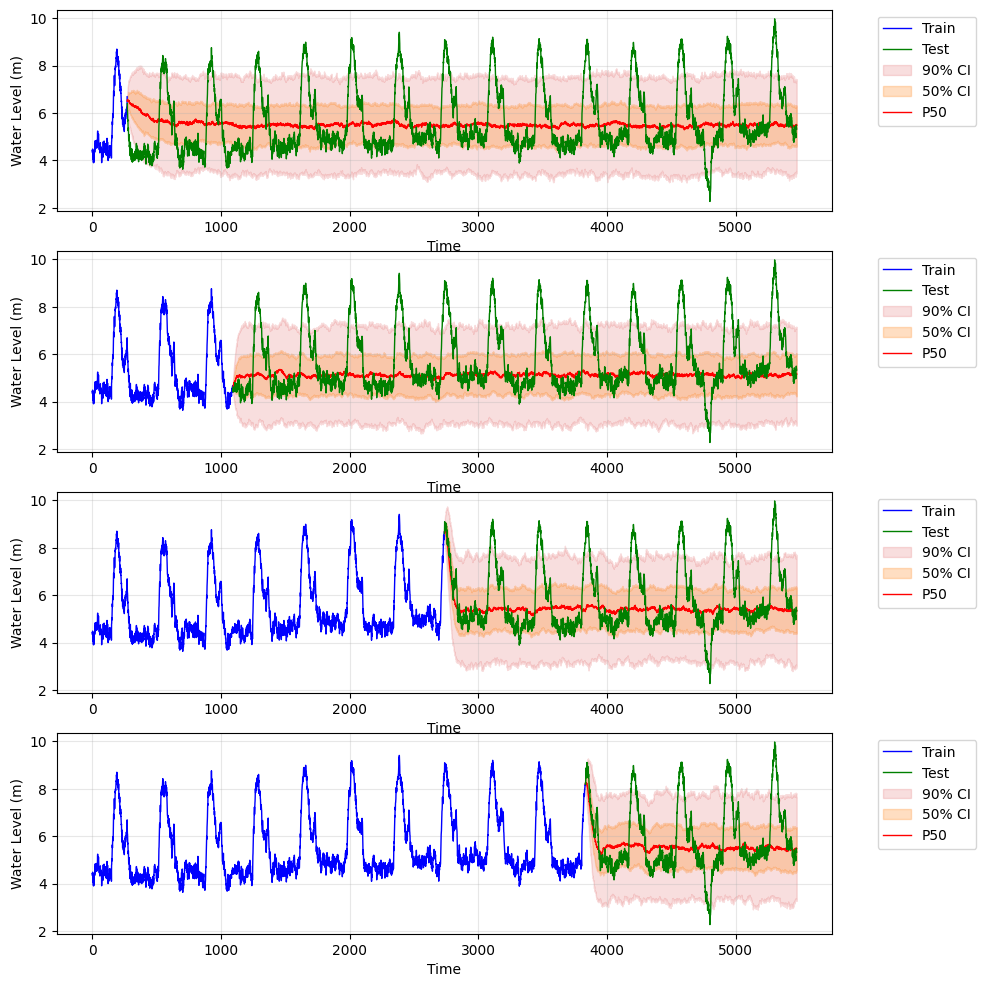

In [17]:
run_tuning("river_monsoon.csv", d_values=[0])

## WF 2B) Test with a nonstationaty series (long term trend on the mean) - use d=0 (no derivative)

This workflow shows ARIMA response to a non-stationary series when d=0.
The model response does not follow the trend of the mean.
It would be necessary to decompose the series before running ARIMA fitting.

Fitting tt_split=0.05 ...
Fitting tt_split=0.2 ...
Fitting tt_split=0.5 ...
Fitting tt_split=0.7 ...
----------
Done
Train-test split: 5.0 %
     (p,d,q):(2, 0, 0)
     Forecast  (mean): 2.71
     Test data (mean): 1.97
     -> Error: 37.23 %
Train-test split: 20.0 %
     (p,d,q):(2, 0, 0)
     Forecast  (mean): 2.89
     Test data (mean): 1.78
     -> Error: 62.31 %
Train-test split: 50.0 %
     (p,d,q):(1, 0, 1)
     Forecast  (mean): 2.48
     Test data (mean): 1.47
     -> Error: 68.26 %
Train-test split: 70.0 %
     (p,d,q):(1, 0, 1)
     Forecast  (mean): 2.20
     Test data (mean): 1.33
     -> Error: 65.03 %


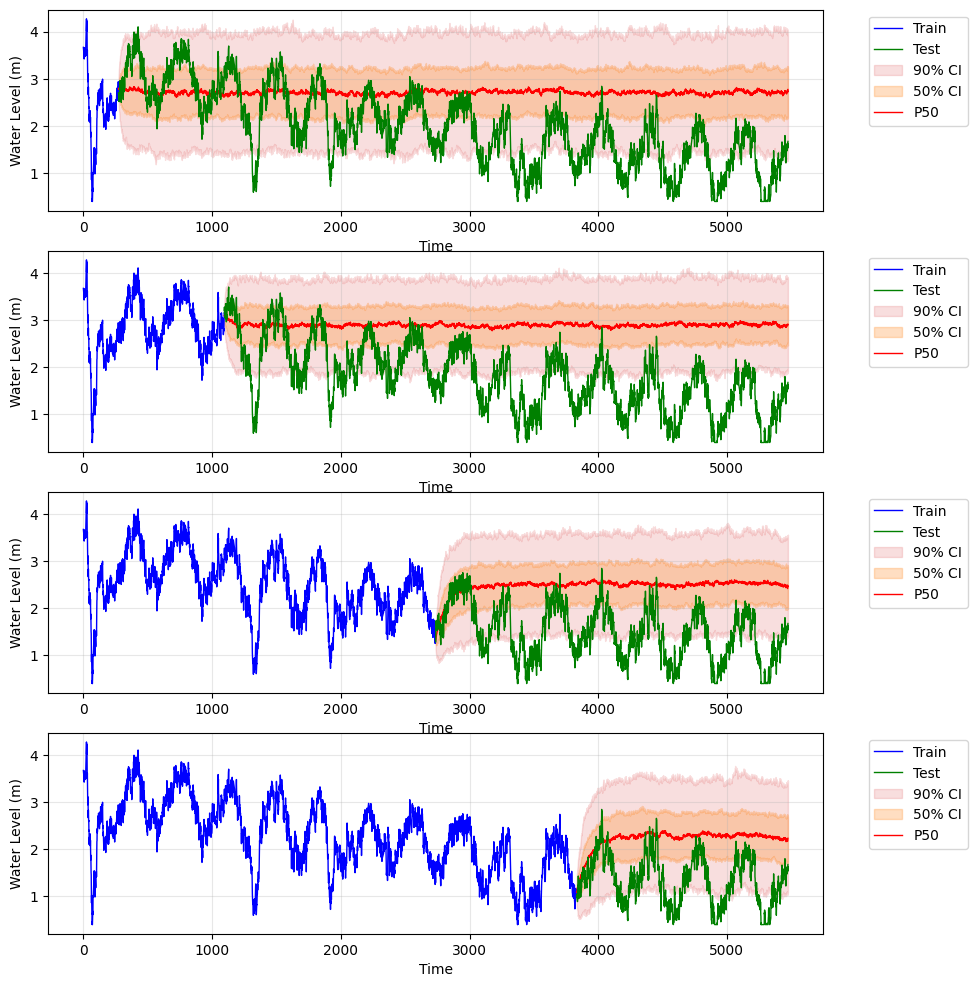

In [18]:
run_tuning("river_climate_change.csv", d_values=[0])

## WF 2B) Test with a nonstationaty series (long term trend on the mean) - use d=1 (derivative)

This workflow shows ARIMA response to a non-stationary series when d=1 (fit to the series derivative).
The model confidence interval now is a cone, and covers the mean evolution.
The 90% interval seems excessively wide, though.

Fitting tt_split=0.05 ...
Fitting tt_split=0.2 ...
Fitting tt_split=0.5 ...
Fitting tt_split=0.7 ...
----------
Done
Train-test split: 5.0 %
     (p,d,q):(2, 1, 2)
     Forecast  (mean): 2.82
     Test data (mean): 1.97
     -> Error: 42.76 %
Train-test split: 20.0 %
     (p,d,q):(0, 1, 1)
     Forecast  (mean): 3.10
     Test data (mean): 1.78
     -> Error: 73.80 %
Train-test split: 50.0 %
     (p,d,q):(0, 1, 1)
     Forecast  (mean): 1.31
     Test data (mean): 1.47
     -> Error: -11.14 %
Train-test split: 70.0 %
     (p,d,q):(0, 1, 1)
     Forecast  (mean): 1.07
     Test data (mean): 1.33
     -> Error: -19.81 %


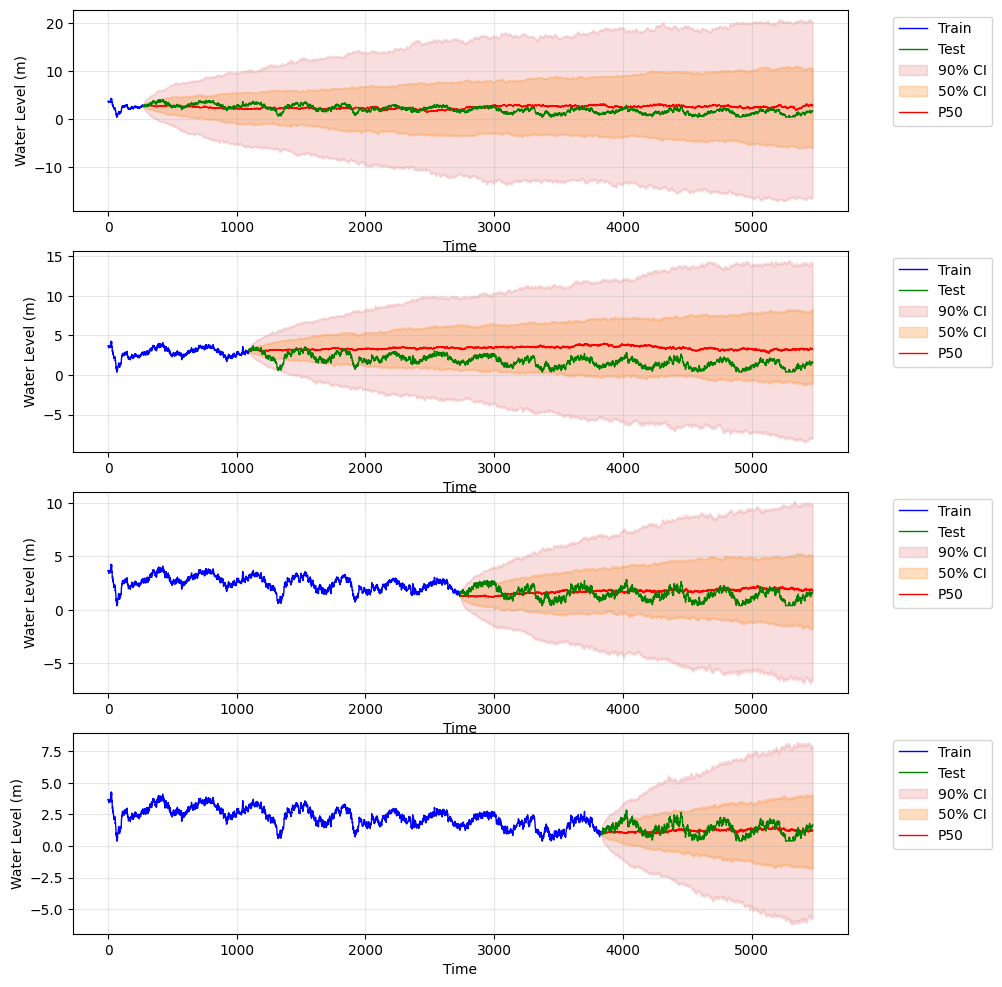

In [19]:
run_tuning("river_climate_change.csv", d_values=[1])

##### **Disclaimer on Artificial Intelligence Usage**

The datasets were designed with AI assistance (claude.ai). I have not extensively verified its consistency and realism. They fit the purpose of the workflows. The initial code of the ARIMA analysis was designed with the assistance of AI. It was completely modified for the purposes of this project. I take full responsibility for the code and for the conclusions drawn.
